In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime
import re
from os import listdir
import sys
import copy as cp
sys.path.insert(0, '../model_tf2')
import parameters
import plotting_functions as pf
import data_utils as du
import model_utils as mu
import behaviour_analyses as ba
import environments as ef
import cell_analyses as ca

In [2]:
path = 'C:/Users/gaumu/Desktop/TEM_linux/Summaries/'
save_dirs = [path]

# Choose which training run data to load
date = '2024-03-11'
run = '0'
index = None  # '1000', None

# grid cells: date = [saved], '2021-10-03', run = '4', index=1000
# grid cells: date = [saved], '2021-09-05', run = '0' (hex grids, square world, relu) 
# - also use for place-grid metric figure
# grid cells: date = [saved], '2021-08-30', run = '3' (hex grids, square world, relu)
# grid cells: date = [saved], '2021-09-29', run = '7' (hex world)
# place cells: date = [saved], '2021-09-29', run = '0'

# Try to find the most recent trained model data to run a forward pass
recent = -1
time_series_smoothing = 1
try:
    # Find model path and iteration index
    save_dir, index = pf.get_model_path(run, date, save_dirs, recent, index=index)
    # Run forward path for retrieved model, if folder doesn't exist yet
    model = ba.save_trained_outputs(date, run, int(index), base_path=save_dir, \
                                    force_overwrite=False, n_envs_save=16)
except FileNotFoundError:
    print('No trained model weights found for ' + date + ', run ' + run + '.')
  



Not running forward pass: C:/Users/gaumu/Desktop/TEM_linux/Summaries/2024-03-11/run0/save/iter_6474 already exists


c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [3]:
# Load data, generated either during training or in a forward pass through a trained model
data, para, list_of_files, save_path, env_dict = pf.get_data(save_dirs, run, date, recent, \
                                                             index=index, \
                                                             smoothing=time_series_smoothing, \
                                                             n_envs_save=16)
# Assign parameters
params, widths, n_states = para

# Specify plotting parameters. Some fields will be added after loading data & parameters
plot_specs = pf.__plot_specs

# Set plot_spec fields that depend on parameters after loading
plot_specs.index = index
plot_specs.world_type = params.world_type
plot_specs.directory = save_path.split('save/')[0]

import seaborn
#sns.set(font_scale = 2)
seaborn.set_style(style='white')
seaborn.set_style({'axes.spines.bottom': False,'axes.spines.left': False,'axes.spines.right': \
                   False,'axes.spines.top': False})

masks, g_lim = pf.sort_data(data.g, widths, plot_specs)

yes C:/Users/gaumu/Desktop/TEM_linux/Summaries/2024-03-11/run0/save
Loading model time point 6474
params path: C:/Users\gaumu\Desktop\TEM_linux\Summaries\2024-03-11\run0\save
Successfully reconstructed run setup data from test_dict
Successfully reconstructed run setup data from test_dict
Successfully loaded timeseries
Successfully reconstructed rate maps from timeseries


In [4]:
masks = [(np.sum(g,1) != 0).tolist() for g in data.g]
trainalbe_variables = model.trainable_weights

In [5]:
for env in range(min(params.n_envs_save, len(data.acc_to))):
    num_correct = np.sum(data.acc_to[env] * data.positions[env])
    proportion = num_correct / sum(data.positions[env])
    _n_states = len(data.positions[env] > 0.01)
    approx_num = proportion * _n_states
    print(env, '   Approx proportion : ', np.round(proportion, decimals=3), \
          '   Approx num : ' + str(int(np.round(approx_num, decimals=4)[0])) \
          + ' of ' + str(_n_states))

0    Approx proportion :  [0.939]    Approx num : 240 of 256
1    Approx proportion :  [0.943]    Approx num : 241 of 256
2    Approx proportion :  [0.909]    Approx num : 262 of 289
3    Approx proportion :  [0.89]    Approx num : 257 of 289
4    Approx proportion :  [0.963]    Approx num : 188 of 196
5    Approx proportion :  [0.957]    Approx num : 215 of 225
6    Approx proportion :  [0.941]    Approx num : 241 of 256
7    Approx proportion :  [0.911]    Approx num : 263 of 289
8    Approx proportion :  [0.96]    Approx num : 188 of 196
9    Approx proportion :  [0.94]    Approx num : 211 of 225
10    Approx proportion :  [0.92]    Approx num : 235 of 256
11    Approx proportion :  [0.902]    Approx num : 260 of 289
12    Approx proportion :  [0.946]    Approx num : 185 of 196
13    Approx proportion :  [0.956]    Approx num : 187 of 196
14    Approx proportion :  [0.958]    Approx num : 215 of 225
15    Approx proportion :  [0.959]    Approx num : 215 of 225


In [6]:
env0 = 2
env1 = 3
envs = [env0, env1]

## GRAPHS

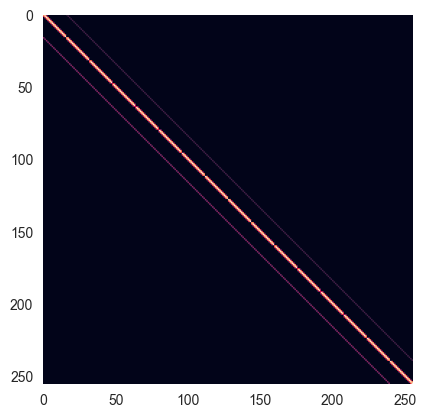

In [7]:
env_ = env_dict.curric_env.envs[0]
env_.world()
# plot different transitions in different colours
for i in range(env_.adj.shape[0]):
    for j in range(env_.adj.shape[1]):
        if env_.adj[i,j] != 0:
            ri, rt = env_.relation(i,j)
            env_.adj[i,j] = ri + 1
plt.imshow(env_.adj)
w,v = np.linalg.eig(env_.adj)

In [8]:
import networkx as nx
try:
    plt.figure(figsize=(10,5))
    for i, env in enumerate([env0, env1]):
        adj_ = pf.remove_zero_adj(data.adj[env])
        plt.subplot(1,2,i + 1)
        g = nx.from_numpy_matrix(adj_)
        pos_nodes = nx.spring_layout(g, iterations=500)
        nx.draw(g, pos=pos_nodes, node_size=50, with_labels=True)
    plt.show()
except TypeError:
    plt.close('all')
    pass

## AGENT COVERAGE

2 63
7 59


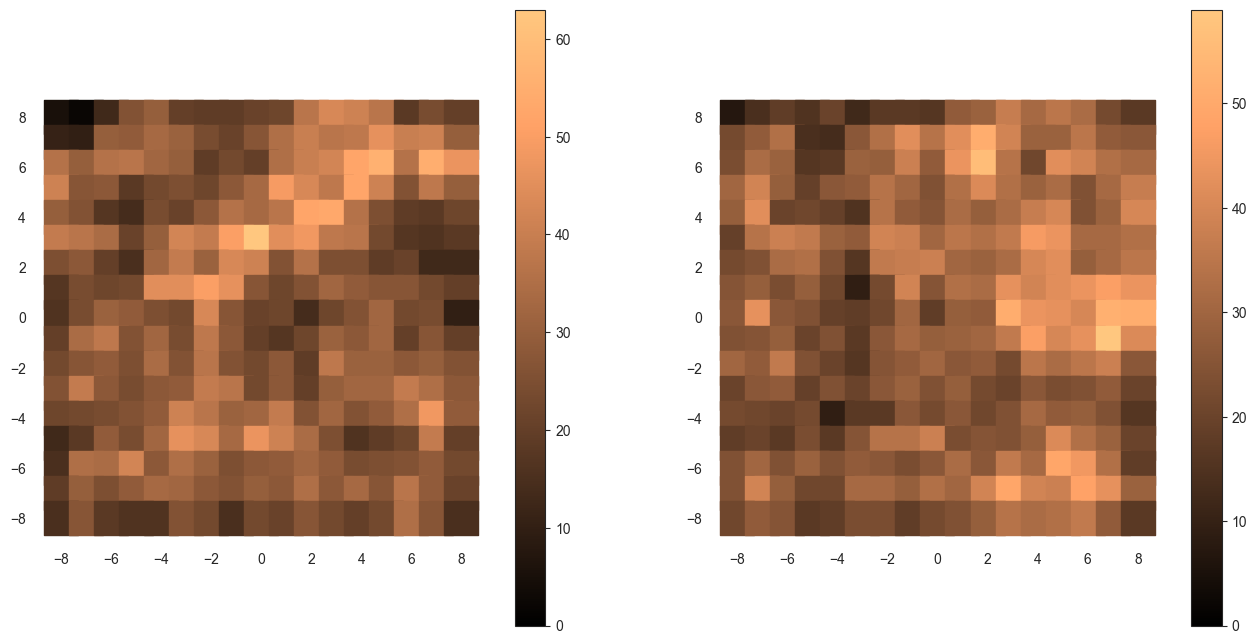

In [9]:
plot_specs.cmap = 'copper'
try:
    s = plot_specs[parameters.old2new(params.world_type)].marker_size
    marker = plot_specs[parameters.old2new(params.world_type)].marker_shape
except:
    print('exceptiom')
    s, marker = 10, 'H'
figsize = (16,8)
s_scale = 20
plt.figure(figsize=figsize) 
for i, env in enumerate([env0, env1]):
    plt.subplot(1,2,i+1)
    pos, bins = np.histogram(data.pos_timeseries[env], bins=np.arange(n_states[env]+1))
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
        cells=pos, _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, s=s*s_scale, marker=marker, vmin=0, \
                cmap=plot_specs.cmap)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    print(min(cell_prepared), max(cell_prepared))
plt.show()

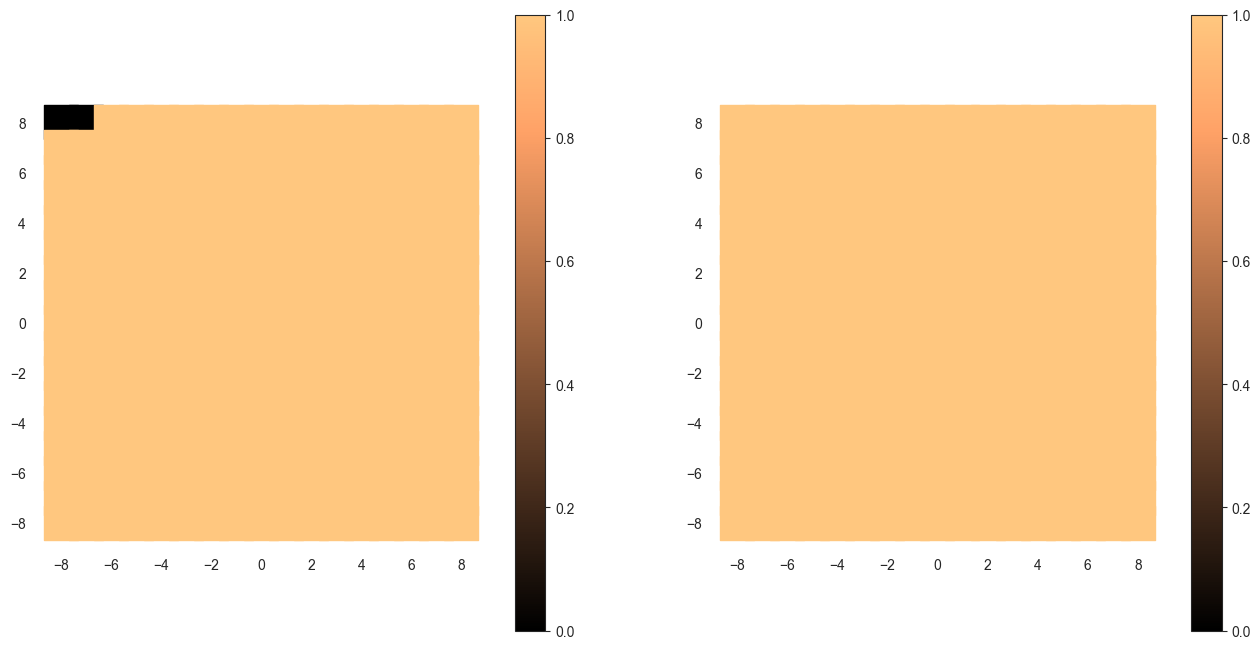

In [10]:
# where the agent didnt go much shown in black
figsize= (8 * len(envs), 8)
plt.figure(figsize=figsize)
s_scale = 20
for i, env in enumerate([env0, env1]):
    pos, bins = np.histogram(data.pos_timeseries[env], bins=np.arange(n_states[env]+1))
    a = pos > 5
    plt.subplot(1,2,i+1)
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
        cells=a.astype(float), _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, s=s*s_scale, marker=marker, vmin=0, cmap=plot_specs.cmap)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()    
plt.show()

## ACCURACY MAPS

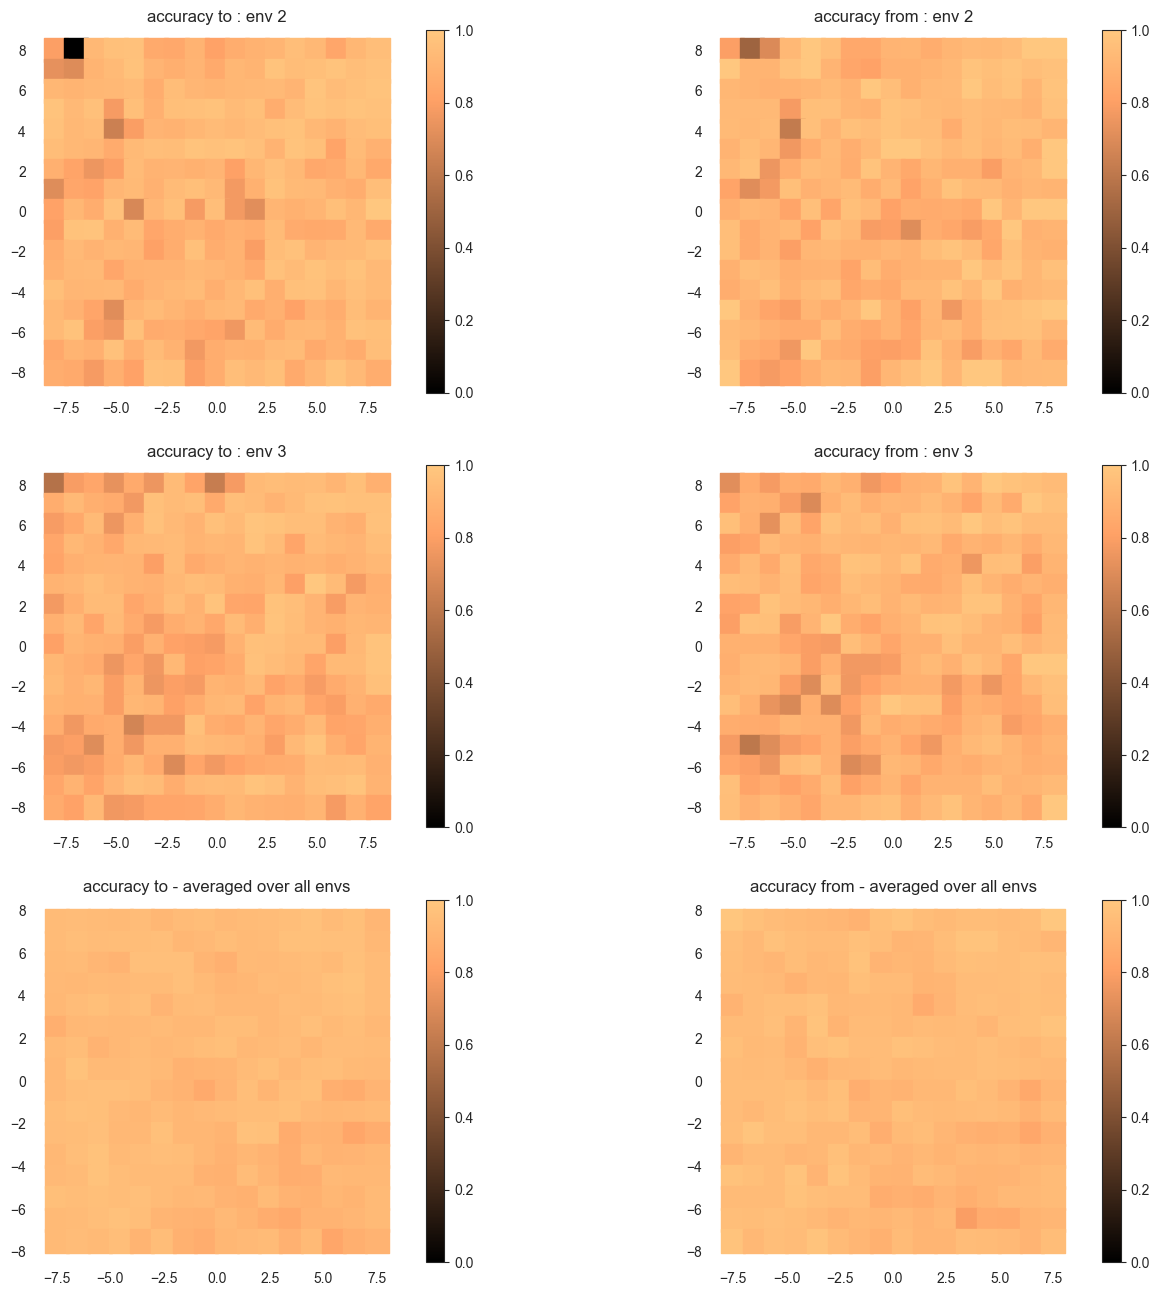

In [11]:
figsize= (8 * len(envs), 16)
s_scale = 10
plt.figure(figsize=figsize)        
for i, env in enumerate([env0, env1]):
    plt.subplot(3,2,2*i+1)    
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
        cells=data.acc_to[env], _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s*s_scale, \
                marker=marker, vmin=0, vmax=1)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    plt.title('accuracy to : env ' + str(env))
    
    plt.subplot(3,2,2*i+2)
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
        cells=data.acc_from[env], _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s*s_scale, \
                marker=marker, vmin=0, vmax=1)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    plt.title('accuracy from : env ' + str(env))
# average across envs - should do this properly with position counts
env = 0
# find other envs of same size
accs_to = [acc_to for i, acc_to in enumerate(data.acc_to) if n_states[i] == n_states[env]]
accs_from = [acc_from for i, acc_from in enumerate(data.acc_from) if n_states[i] == n_states[env]]

plt.subplot(3,2,5)
xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
    cells=np.mean(accs_to, axis=0), _plot_specs=plot_specs)
plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s*s_scale, \
            marker=marker, vmin=0, vmax=1)
plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.title('accuracy to - averaged over all envs')
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(3,2,6)
xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(
    cells=np.mean(accs_from, axis=0), _plot_specs=plot_specs)
plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s*s_scale, \
            marker=marker, vmin=0, vmax=1)
plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.title('accuracy from - averaged over all envs')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Inner-prods and softmax probs

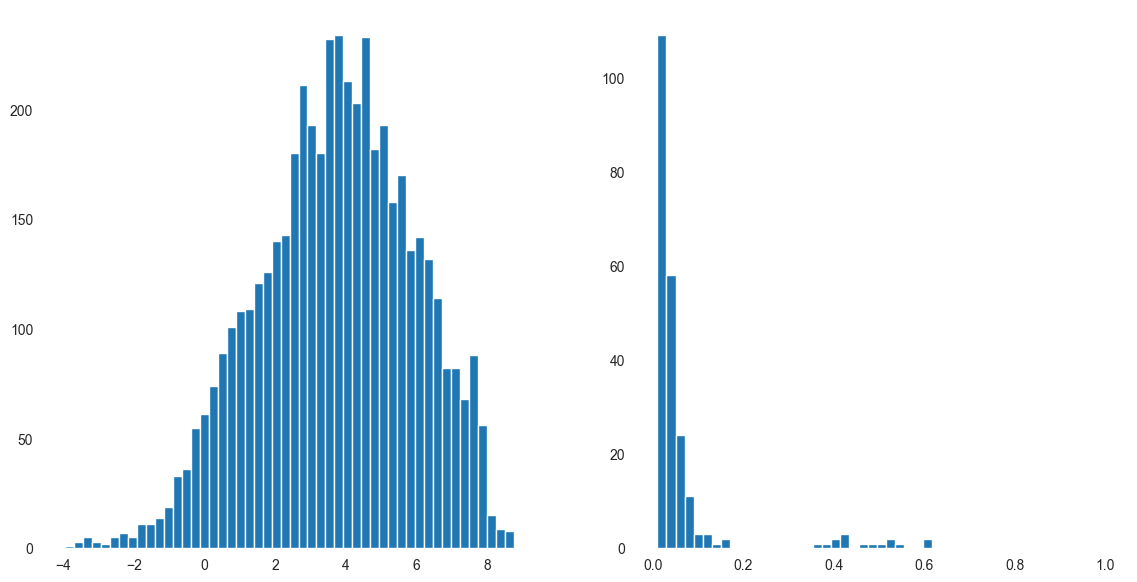

In [12]:
#variables = model_utils.DotDict(np.load('/Users/jameswhittington/Dropbox/gen_struct_know/model_tf2' + '/asdsad.npy', allow_pickle=True).item())
lookback=1
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
_ = plt.hist(np.stack(data.final_variables.mem_dist.inner_prods)[-lookback:,...].flatten() \
             [np.stack(data.final_variables.mem_dist.inner_prods)[-lookback:,...].flatten() \
              > -100], bins=50)
plt.subplot(1,2,2)
_ = plt.hist(np.stack(data.final_variables.mem_dist.probabilities)[-lookback:,...].flatten(), \
             bins=np.linspace(0.01, 1, 50))
plt.savefig(plot_specs.directory + 'scal_prods_probs' + '_' + plot_specs.index + ".pdf")

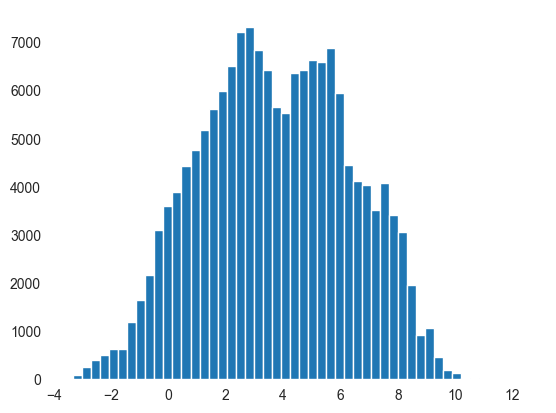

In [13]:
g_reps = data.g_timeseries[0][:,:400].T
reps = model.g2p(g_reps).numpy()
n_k = reps.shape[-1]
scal_prods = np.matmul(reps, reps.T)
scal_prods = mu.threshold(scal_prods, n_k*params.kernel_thresh_min, \
                          n_k*params.kernel_thresh_max, thresh_slope=0.001).numpy()
scal_prods = scal_prods / np.sqrt(reps.shape[-1])
_ = plt.hist(scal_prods.flatten(), bins=50)

## ENTORHINAL CELLS

In [14]:
plot_specs.split_freqs = False
plot_specs.n_cells_freq = params.g_size
plot_specs.cmap = 'jet'
plot_specs.node_plot = True
plot_specs.max_min = True
plot_specs.smoothing = 0.5

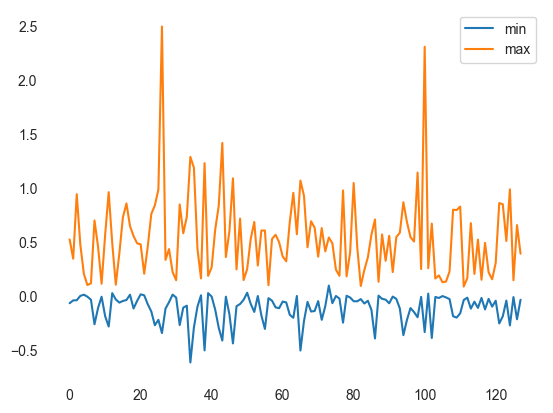

In [15]:
plt.plot(g_lim[0], label='min')
plt.plot(g_lim[1], label='max')
plt.legend()
plt.savefig(plot_specs.directory + 'g_max_min' + '_' + plot_specs.index + ".pdf")

In [16]:
# pf.square_plot(data.g, env0, params, plot_specs, name='g0_'+index, lims=g_lim, mask=masks[env0], \
#                env_class=env_dict.curric_env.envs[env0], fig_dir=plot_specs.directory)

In [17]:
# pf.square_plot(data.g, env1, params, plot_specs, name='g1_'+index, lims=g_lim, mask=masks[env1], \
#                env_class=env_dict.curric_env.envs[env1], fig_dir=plot_specs.directory)

## ENTORHINAL AUTOCORRELATIONS

In [18]:
plot_specs.graph_auto = True
# pf.square_autocorr_plot(data.g, env0, params, plot_specs, name='g0_auto')

In [19]:
#pf.square_autocorr_plot(data.g, env1, params, plot_specs, name='g1_auto')

## 'Place' Cells

In [20]:
gs=[]
for i, g_b in enumerate(data.g):
    gs_b = []
    for j in range(params.max_states):
        try:
            g = g_b[j]
        except IndexError:
            g = np.zeros(params.g_size)
            
        gs_b.append(g)
    gs.append(np.stack(gs_b, axis=0))
gs = np.stack(gs, axis=1)

# repeat gs to get correct batch size:
reps = np.ceil(params.batch_size/gs.shape[1]).astype(int)
gs = np.tile(gs, [1,reps,1])
gs = gs[:,:params.batch_size,:]

In [21]:
# place cells

ps = []
g2ps = []
for g in gs:
    train_i = 1000000
    scalings = parameters.get_scaling_parameters(train_i, params)
    inputs_test_tf = mu.inputs_2_tf(env_dict.inputs, env_dict.hebb, scalings)
    memories_dict, variable_dict = model.init_input(inputs_test_tf)
    mem_step = model.mem_step(memories_dict, 0)

    retrieved_g2x, g_mem_input, hidden_g2x = model.gen_p(g, mem_step)
    
    g2ps.append(model.g2p(g).numpy())
    
    ps.append(hidden_g2x['stored']['prob'].numpy())
ps = np.stack(ps, axis=1)
g2ps = np.stack(g2ps, axis=1)

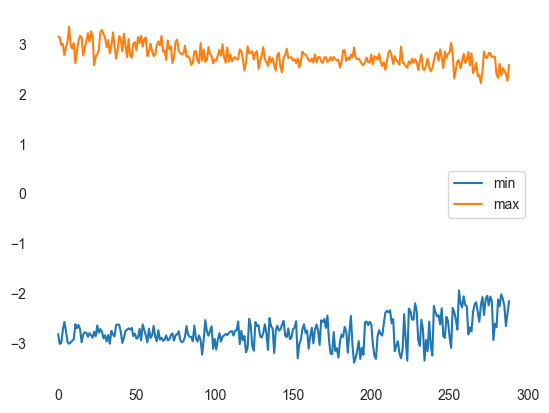

In [22]:
plt.plot(np.min(g2ps, axis=(0,2)), label='min')
plt.plot(np.max(g2ps, axis=(0,2)), label='max')
plt.legend()
plt.savefig(plot_specs.directory + 'g2p_max_min' + '_' + plot_specs.index + ".pdf")

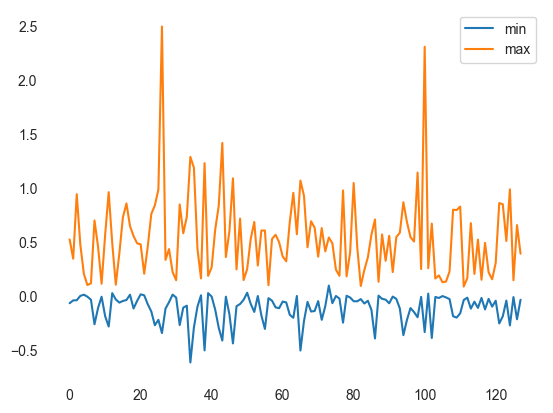

In [23]:
plt.plot(g_lim[0], label='min')
plt.plot(g_lim[1], label='max')
plt.legend()

In [24]:
g2ps_ = []
for b, g2p in enumerate(g2ps):
    g2ps_.append(g2p[:env_dict.curric_env.envs[b].n_states,:])

# pf.square_plot(g2ps_, env0, params, plot_specs, name='g2p0_'+index, lims=None, mask=masks[env0], \
#                env_class=env_dict.curric_env.envs[env0], fig_dir=plot_specs.directory)

In [25]:
ps_ = []
for b, p in enumerate(ps):
    ps_.append(p[:env_dict.curric_env.envs[b].n_states,:])
# pf.square_plot(ps_, env0, params, plot_specs, name='p0_'+index, lims=None, mask=masks[env0], \
#                env_class=env_dict.curric_env.envs[env0], fig_dir=plot_specs.directory)  

# Grid score analysis

In [26]:
from tqdm import tqdm

0it [00:00, ?it/s]c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
2it [00:02,  1.00it/s]c:\Users\gaumu\Desktop\TEM_linux\model_tf2\../model_tf2\cell_analyses.py:240: RuntimeWarning: invalid value encountered in sqrt
  semi_minor = -np.sqrt(m1 * (a + c - np.sqrt((a - c) ** 2 + b * b))) / discrim
28it [00:27,  1.01it/s]c:\Users\gaumu\Desktop\TEM_linux\model_tf2\../model_tf2\cell_analyses.py:239: RuntimeWarning: invalid value encountered in sqrt
  semi_major = -np.sqrt(m1 * (a + c + np.sqrt((a - c) ** 2 + b * b))) / discrim
29it [0

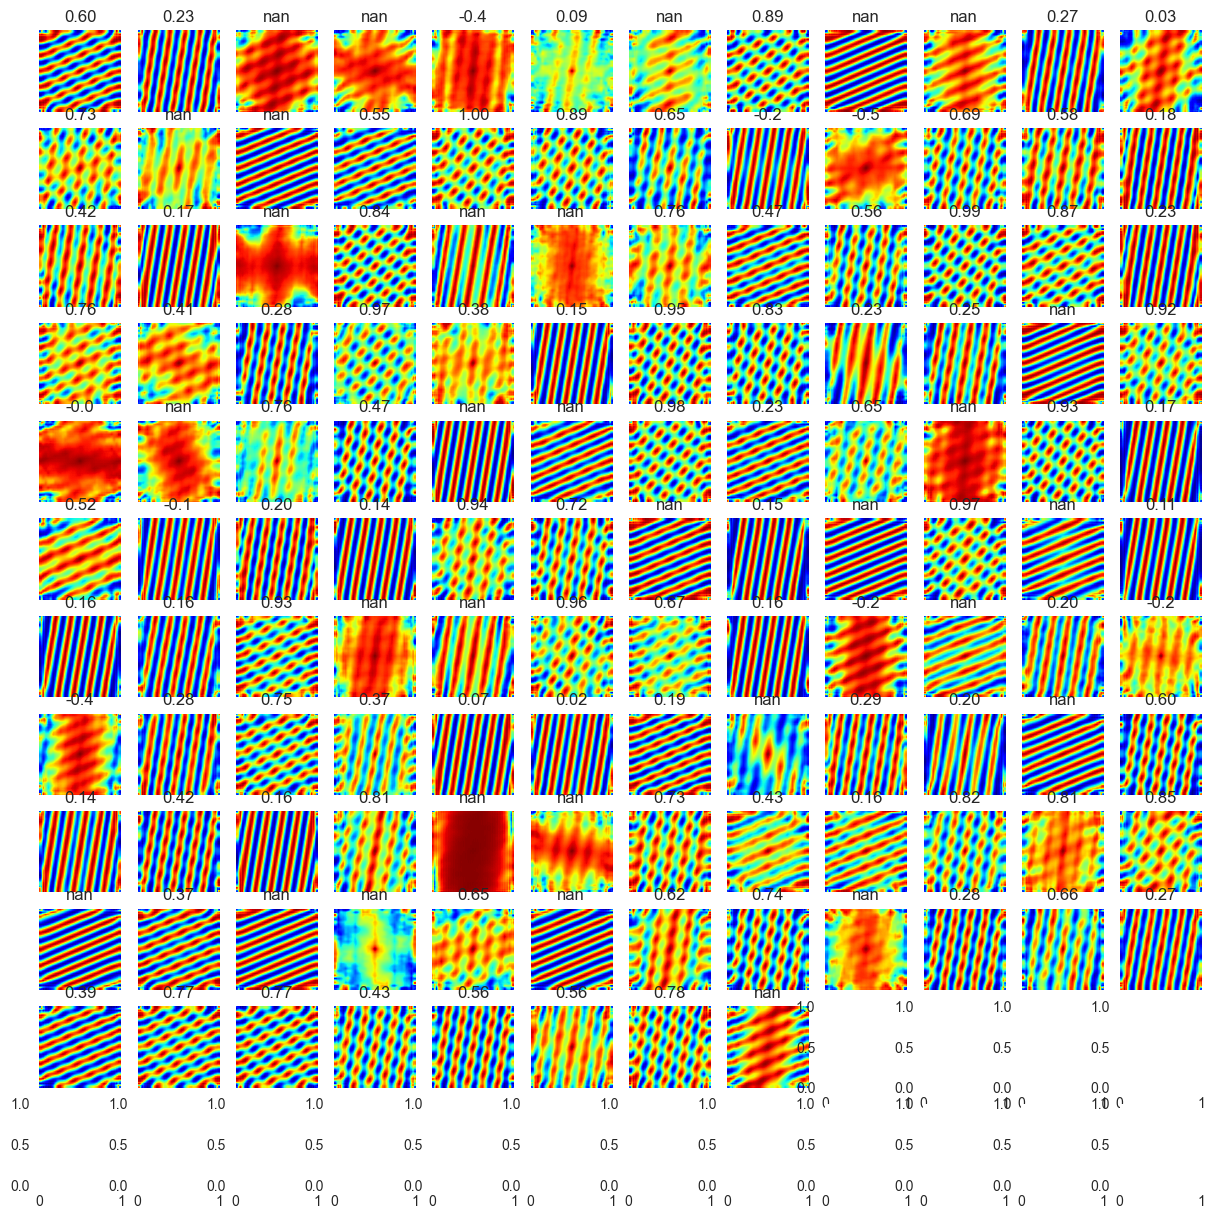

In [27]:
"""
Grid score and scale
"""
fit_ellipse = True
ring = True

module_analysis_gc = []

env=env1

rows = np.ceil(np.sqrt(data.g[env].shape[1])).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(15, 15))

scores_all = []
for i, cell in tqdm(enumerate(data.g[env].T)): 
    # if i%10 ==0:
    #     print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)           
    auto = pf.autocorr2d_no_nans(rate_map) 
    auto = np.nan_to_num(auto, nan=0)
    score, scale, theta = ca.grid_score_scale_analysis(auto, fit_ellipse=fit_ellipse, ring=ring)
    scores_all.append(score)
    norm_firing = np.mean(cell**2)
    
    #if score > -1.0:
    module_analysis_gc.append([i, score, scale, theta, norm_firing])
    
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(auto, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title(str(score)[:4])  

plt.savefig(plot_specs.directory + 'auto_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()
    
scores, scales, thetas, norm_firings = [], [], [], []
for x in module_analysis_gc:
    scores.append(x[1])
    scales.append(x[2])
    thetas.append(x[3])
    norm_firings.append(x[4])
        
scores = np.asarray(scores)
scales = np.asarray(scales)
thetas = np.asarray(thetas)
norm_firings = np.asarray(norm_firings)

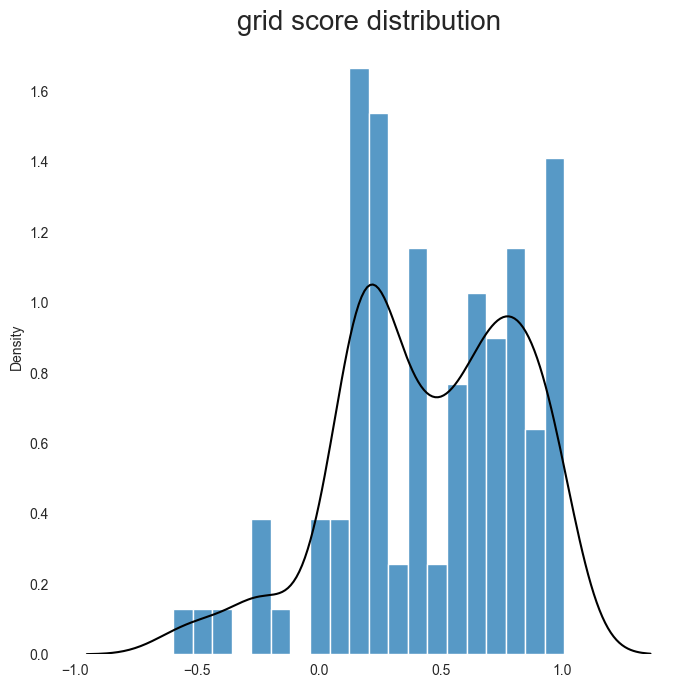

In [28]:
# plot score distribution
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(ax=axes, data=scores, bins=20, stat='density')
sns.kdeplot(ax=axes, data=scores, bw_method='scott', bw_adjust=0.8, c='k')
axes.set_title('grid score distribution', fontsize=20)
plt.savefig(plot_specs.directory + 'grid_score_distribution' + '_' + plot_specs.index + ".pdf", dpi=300)

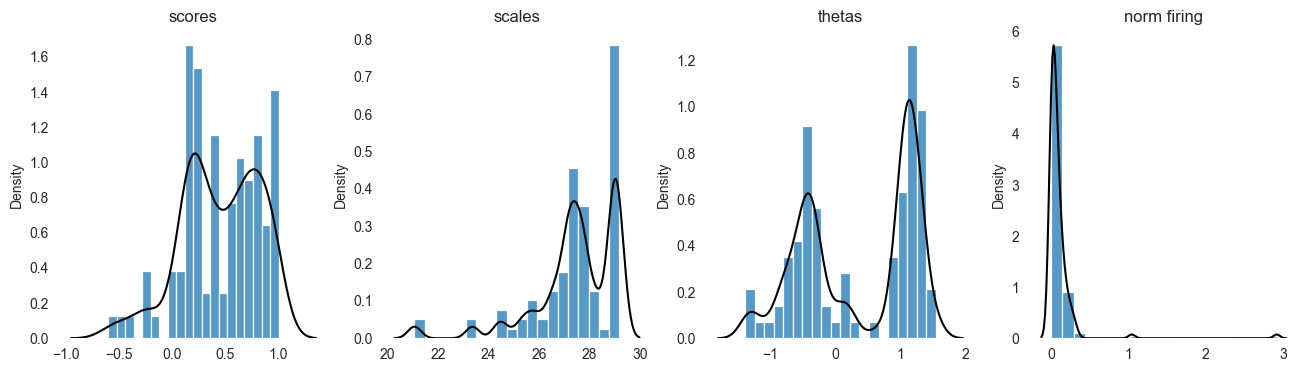

In [29]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(ax=axes[0], data=scores, bins=20, stat='density')
sns.kdeplot(ax=axes[0], data=scores, bw_method='scott', bw_adjust=0.8, c='k')
axes[0].set_title('scores')

sns.histplot(ax=axes[1], data=scales, bins=20, stat='density')
sns.kdeplot(ax=axes[1], data=scales, bw_method='scott', bw_adjust=0.4, c='k')
axes[1].set_title('scales')

sns.histplot(ax=axes[2], data=thetas, bins=20, stat='density')
sns.kdeplot(ax=axes[2], data=thetas, bw_method='scott', bw_adjust=0.4, c='k')
axes[2].set_title('thetas')

sns.histplot(ax=axes[3], data=norm_firings, bins=20, stat='density')
sns.kdeplot(ax=axes[3], data=norm_firings, bw_method='scott', bw_adjust=0.4, c='k')
axes[3].set_title('norm firing')

plt.savefig(plot_specs.directory + 'scores_scales_thetas' + '_' + plot_specs.index + ".pdf", dpi=300)

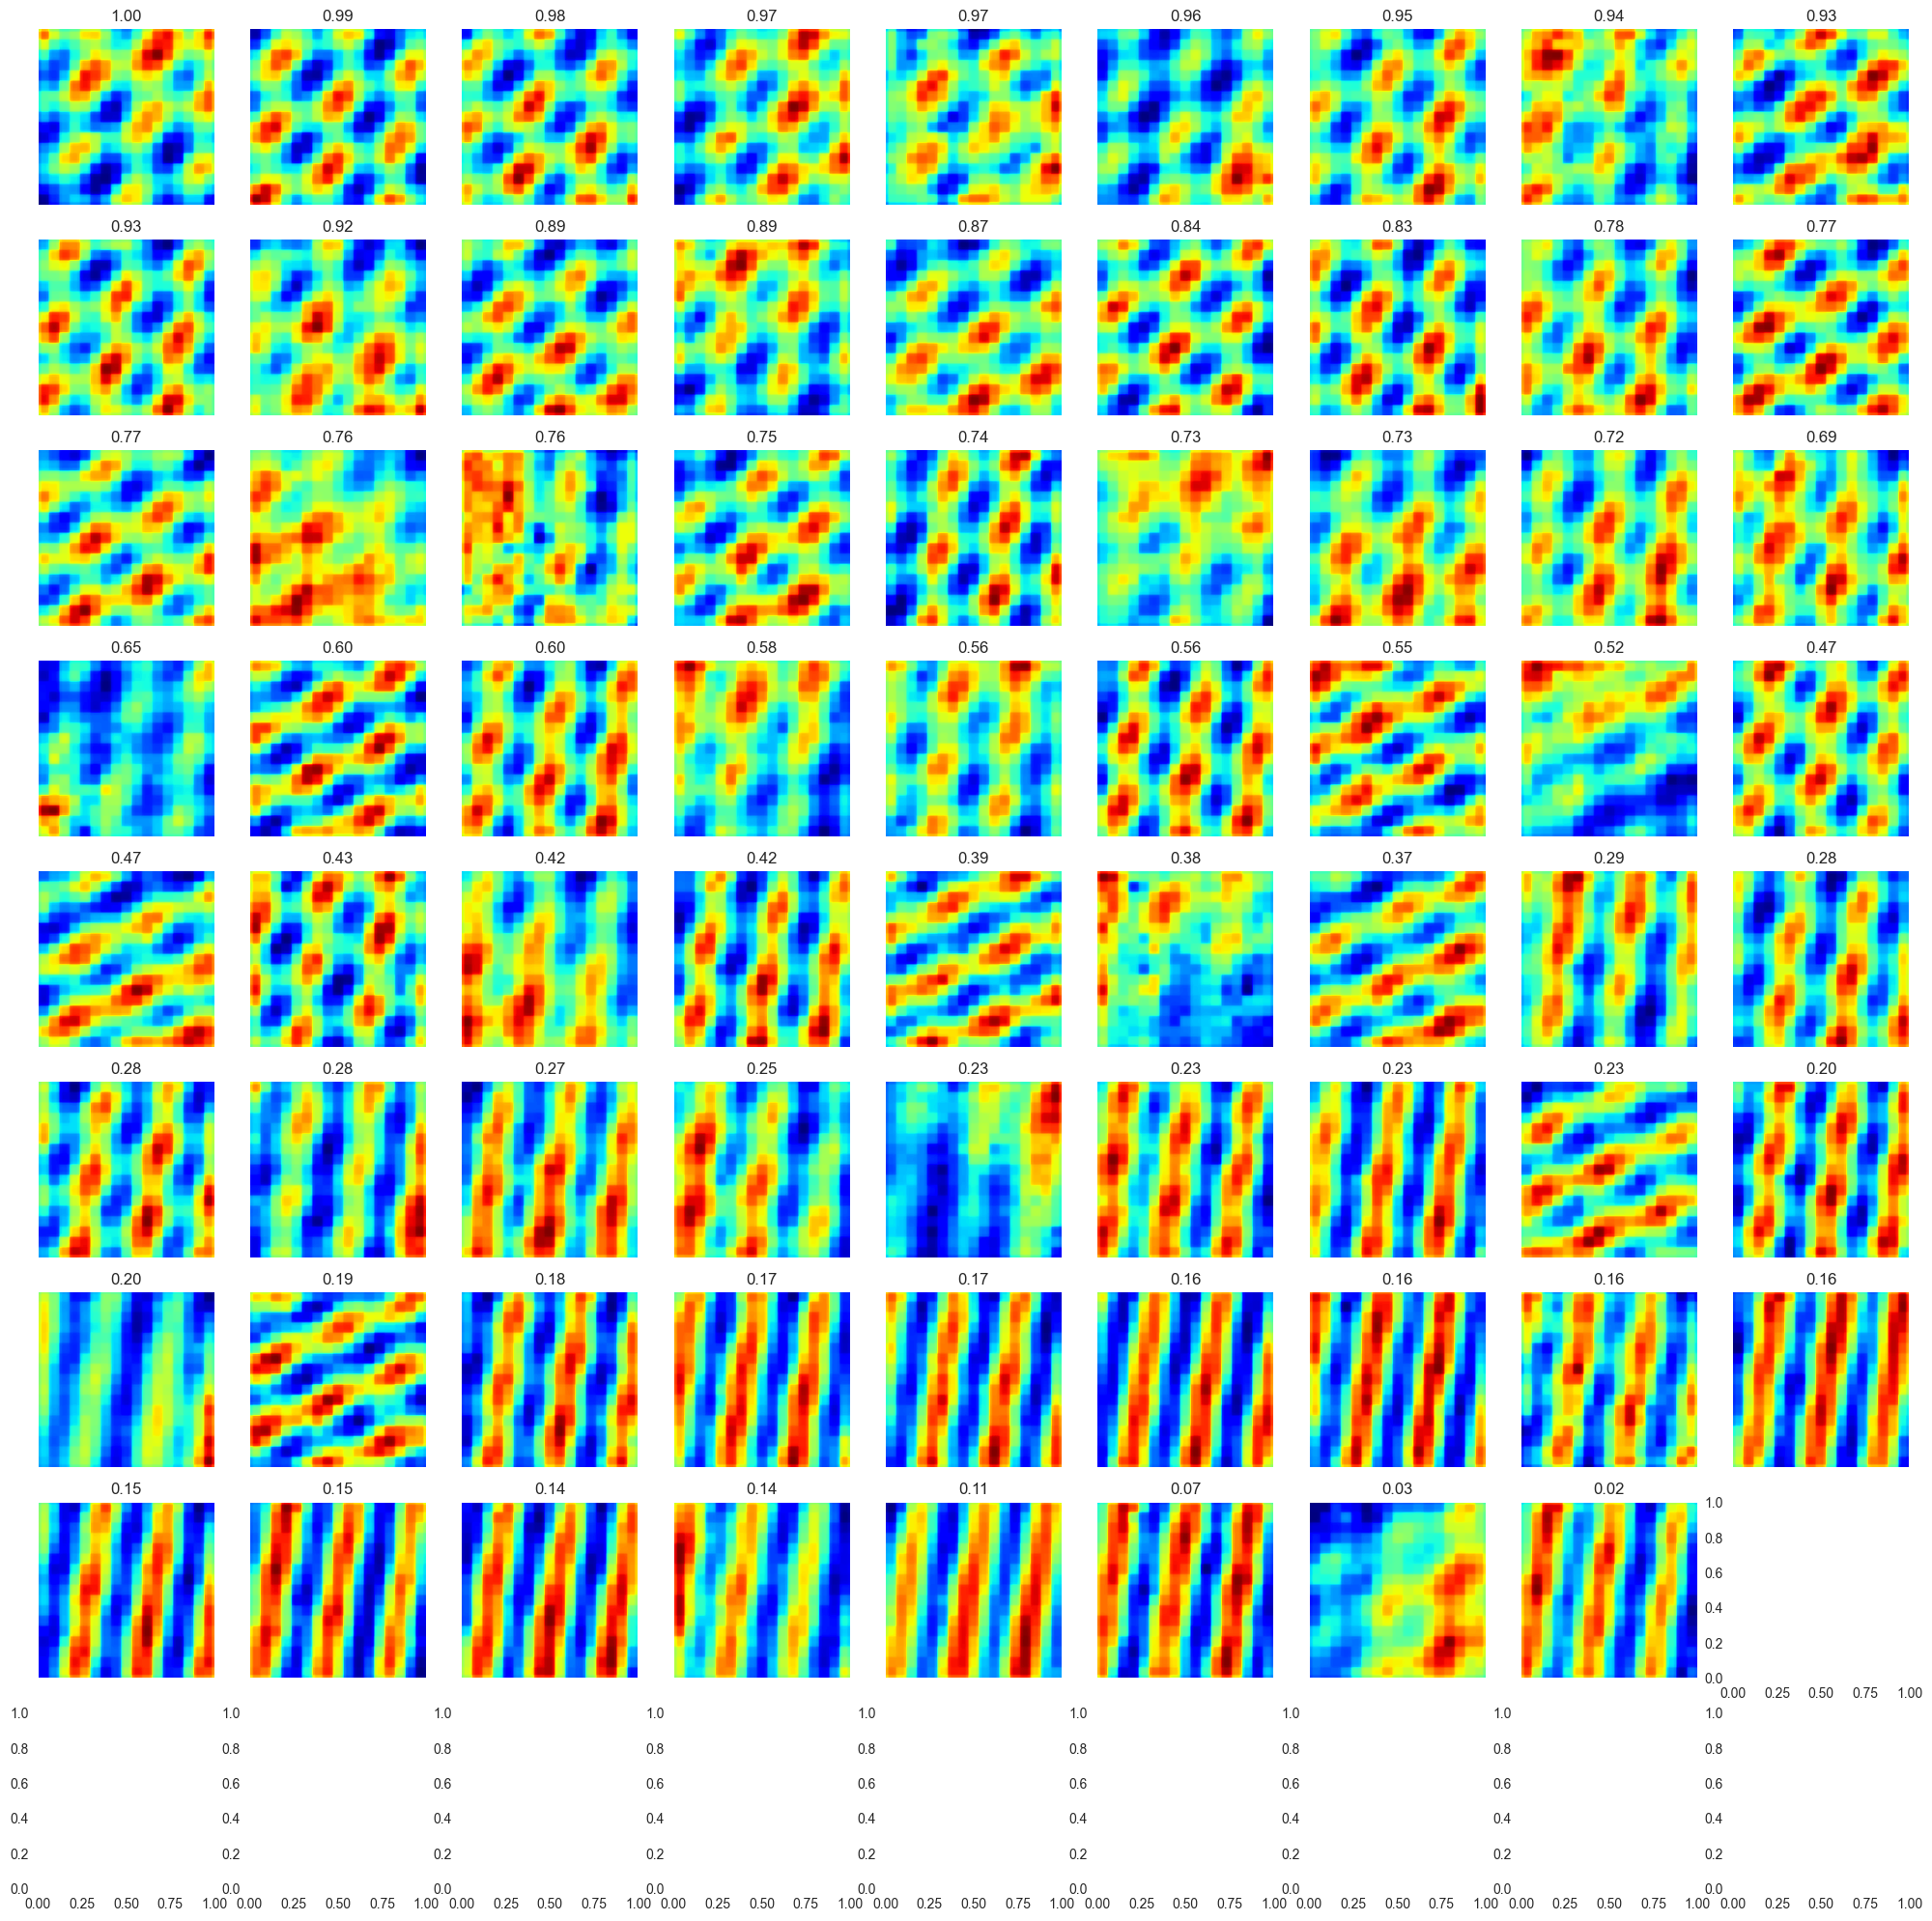

In [30]:
# plot cells with gird score over threshold
module_analysis_gc_array = np.asarray(module_analysis_gc)
thresh = 0.0
norm_thresh = 0.01
over_thresh = module_analysis_gc_array[module_analysis_gc_array[:,1] > thresh, :]
over_thresh = over_thresh[over_thresh[:,4] > norm_thresh]
# sort accorinding to grid score
over_thresh = over_thresh[(-over_thresh[:, 1]).argsort()]

n_cells = over_thresh.shape[0]
rows = np.ceil(np.sqrt(n_cells)).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(25, 25))
for i, cell_num in enumerate(over_thresh[:,0]):
    cell_num = int(cell_num)
    cell = data.g[env][:,cell_num]
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(rate_map, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(over_thresh[i,1])[:4])  
    
plt.savefig(plot_specs.directory + 'ordered_by_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()

# Place cell analysis

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

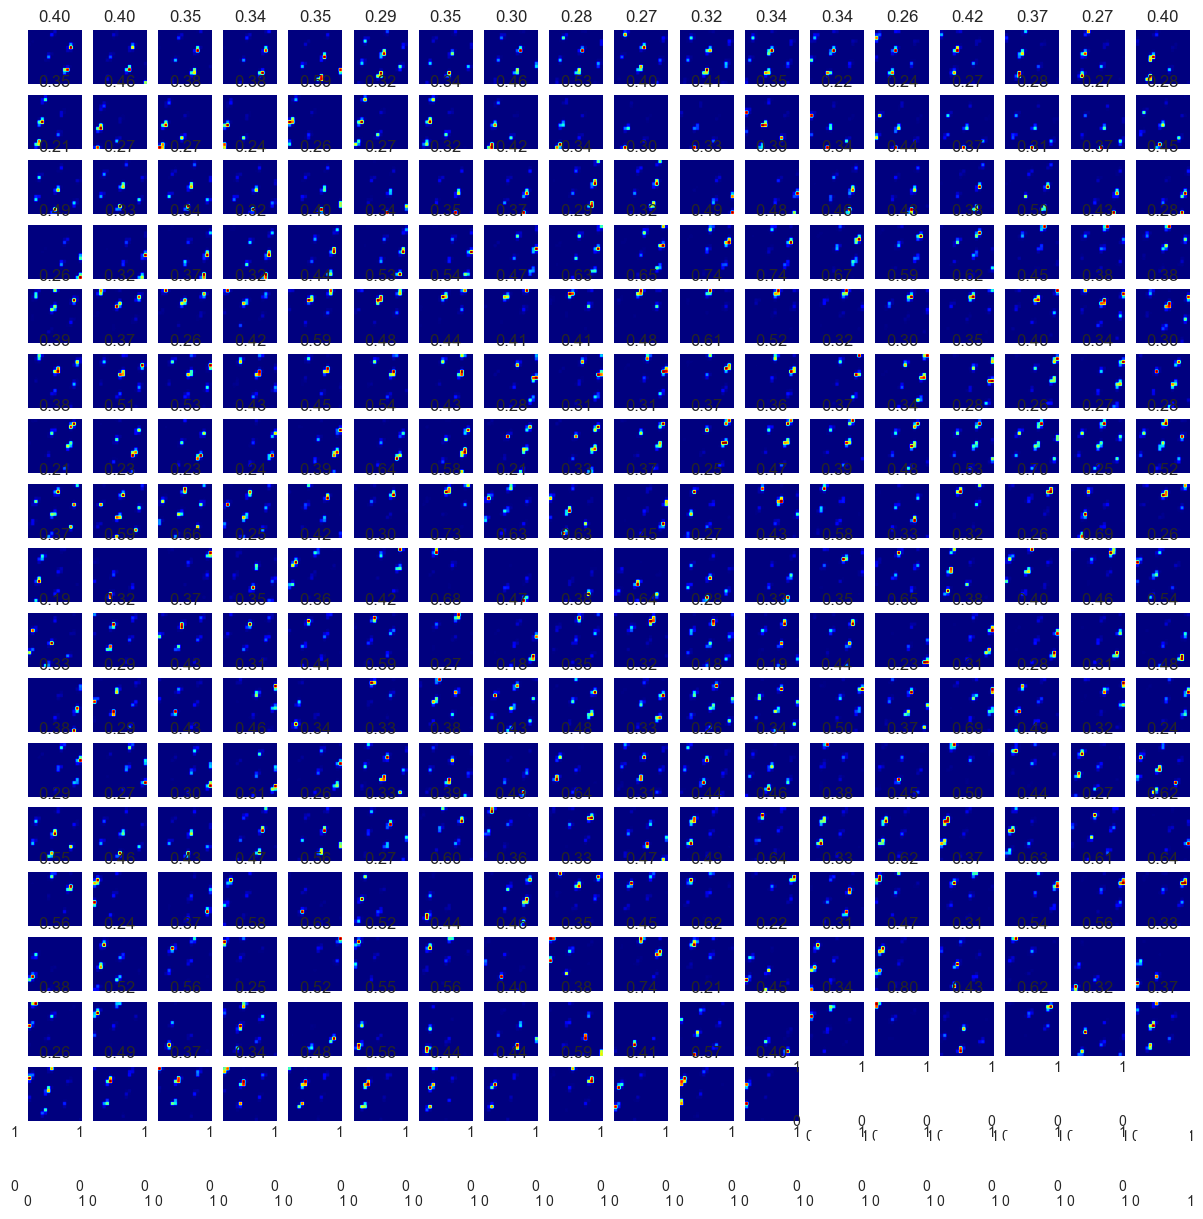

In [31]:
"""
Place score
"""

env=env1

rows = np.ceil(np.sqrt(ps_[env].shape[1])).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(15, 15))

scores_all = []
for i, cell in enumerate(ps_[env].T): 
    if i%10 ==0:
        print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)    
    
    score = ca.place_cell_metric(rate_map)
    scores_all.append(score)
    
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(rate_map, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(score)[:4])  

plt.savefig(plot_specs.directory + 'place_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()
    
scores = np.asarray(scores_all)

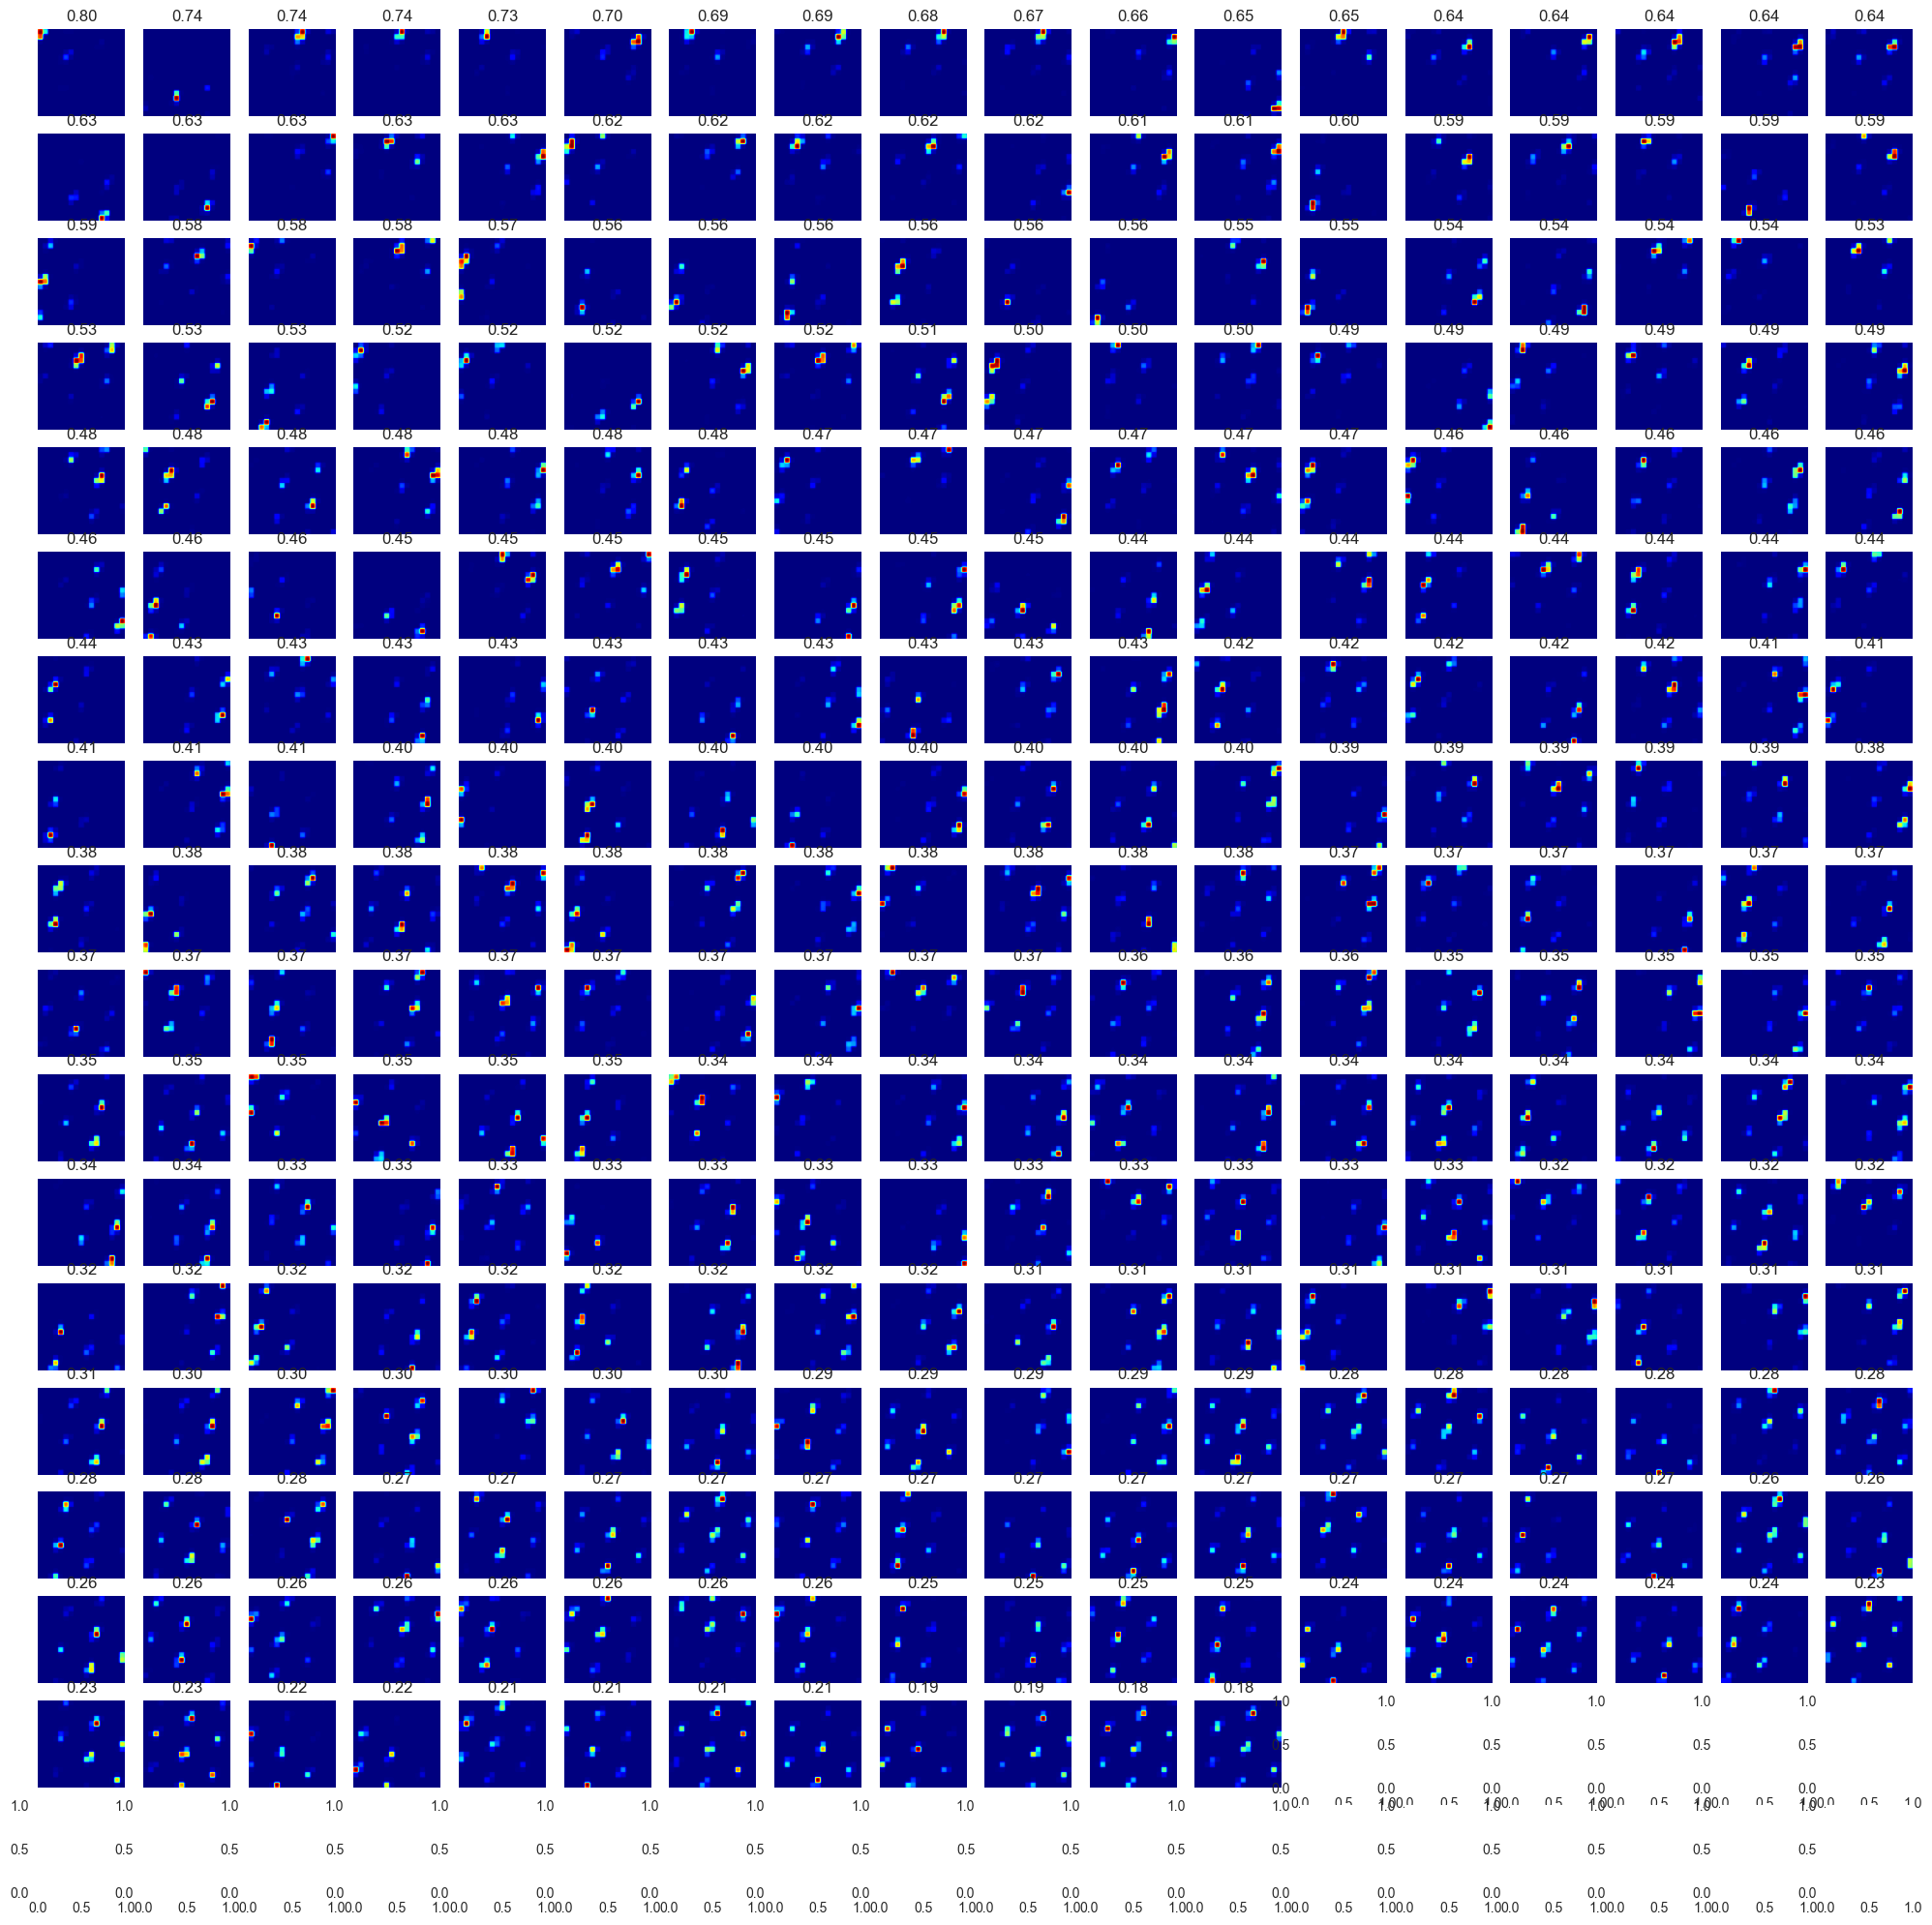

In [32]:
cell_num_ordered = np.arange(len(scores))[(-scores).argsort()]
scores_ordered = scores[(-scores).argsort()]
cell_num_ordered = cell_num_ordered[np.isfinite(scores_ordered)]
scores_ordered = scores_ordered[np.isfinite(scores_ordered)]

n_cells = len(scores_ordered)
rows = np.ceil(np.sqrt(n_cells)).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(25, 25))

for i, (cell_num, score) in enumerate(zip(cell_num_ordered, scores_ordered)):
    cell_num = int(cell_num)
    cell = ps_[env][:,cell_num]
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(rate_map, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(score)[:4])  
    
plt.savefig(plot_specs.directory + 'place_ordered_by_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

128it [00:00, 1272.22it/s]
C:\Users\gaumu\AppData\Local\Temp\ipykernel_38432\3214512596.py:38: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes, data=scores_gc, bw_method='scott', bw_adjust=0.4, c='k')


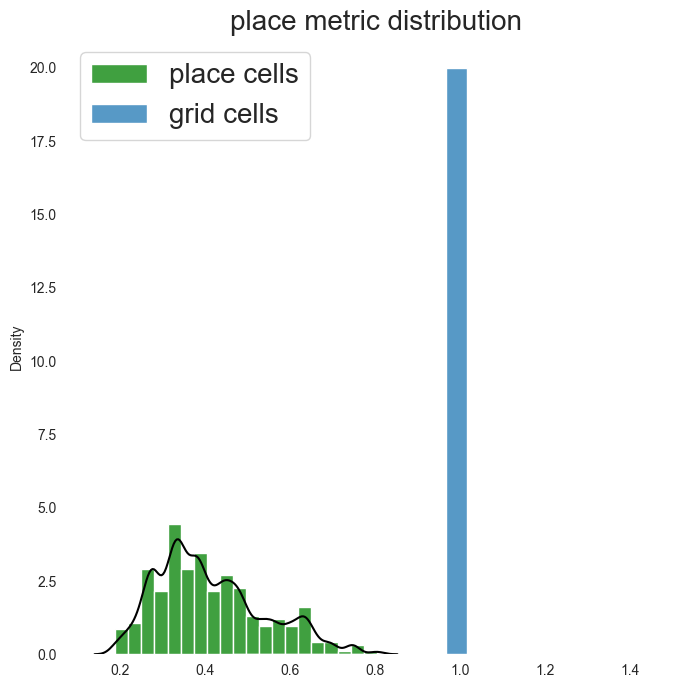

In [33]:
"""
Compare grid to place
"""

env=env1

scores_all = []
for i, cell in enumerate(ps_[env].T): 
    if i%10 ==0:
        print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)    
    
    score = ca.place_cell_metric(rate_map)
    scores_all.append(score)
    
scores_pc = np.asarray(scores_all)

scores_all = []
for i, cell in tqdm( enumerate(data.g[env].T)): 
    # if i%10 ==0:
    #     print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)    
    norm_firing = np.mean(cell**2)
    
    if norm_firing > norm_thresh and i in np.asarray(module_analysis_gc)[:,0]:
        a = np.argmax(np.asarray(module_analysis_gc)[:,0] == i)
        if np.asarray(module_analysis_gc)[a, 1] > 1.0:
            score = ca.place_cell_metric(rate_map)
            scores_all.append(score)
    
scores_gc = np.asarray(scores_all)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(ax=axes, data=scores_pc, bins=20, stat='density', label='place cells',color='g')
sns.kdeplot(ax=axes, data=scores_pc, bw_method='scott', bw_adjust=0.4, c='k')

sns.histplot(ax=axes, data=scores_gc, bins=20, stat='density', label='grid cells')
sns.kdeplot(ax=axes, data=scores_gc, bw_method='scott', bw_adjust=0.4, c='k')

axes.set_title('place metric distribution', fontsize=20)
axes.legend(fontsize=20)

#plt.hist(scores_pc, bins=20, range=[0,1], density=True, label='place cells')
#plt.hist(scores_gc, bins=20, range=[0,1], density=True, label='grid cells')
plt.savefig(plot_specs.directory + 'place_grid_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

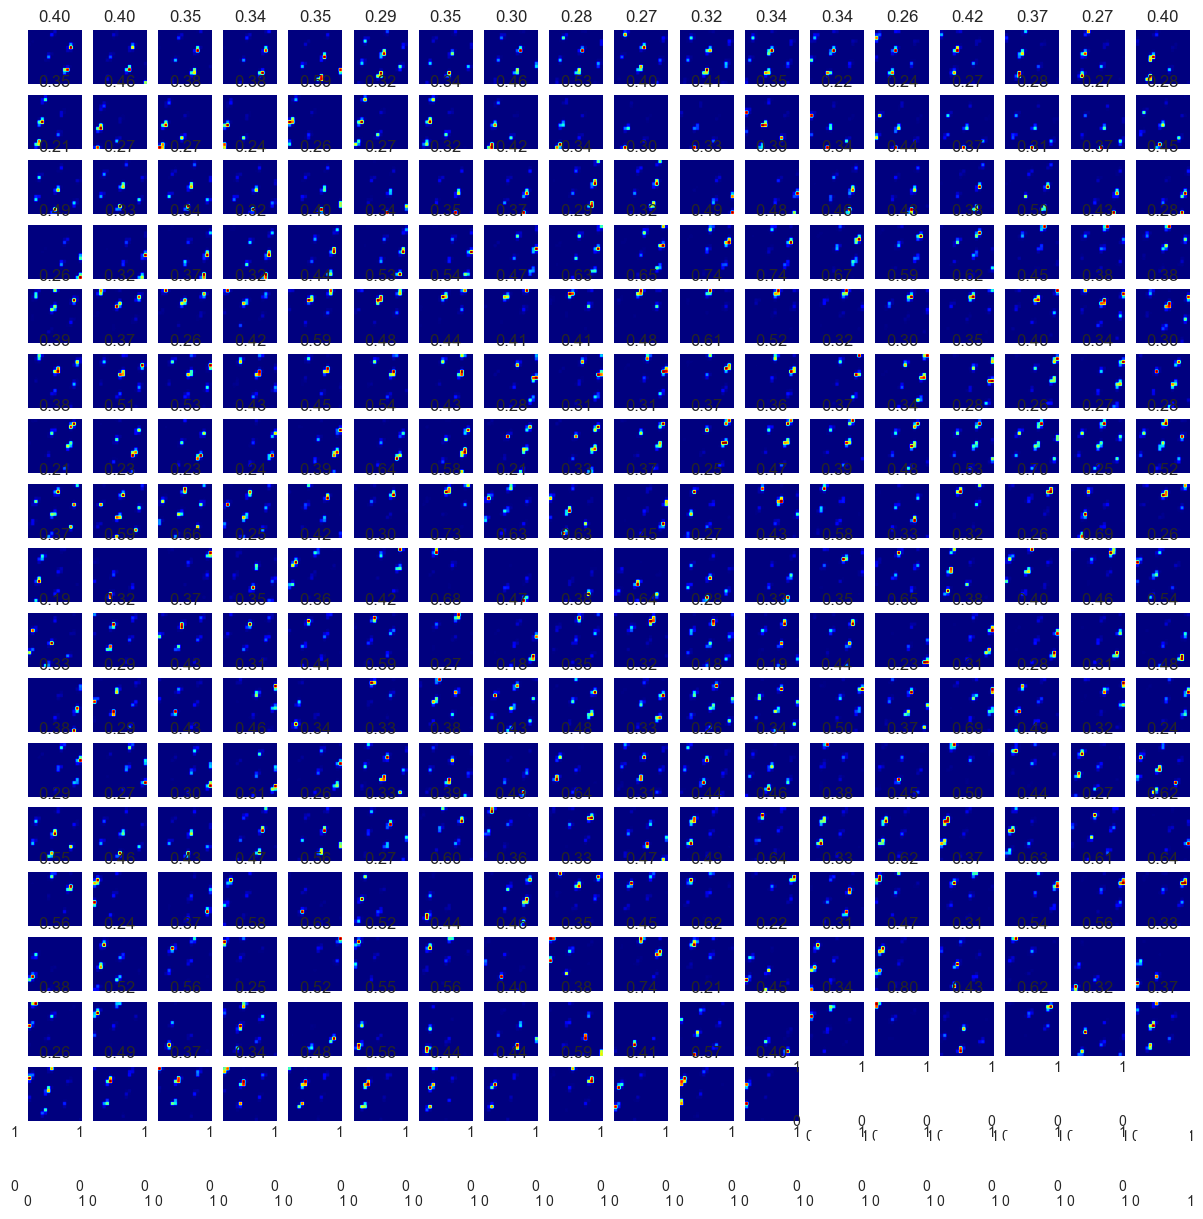

In [34]:
"""
Place score
"""

env=env1

rows = np.ceil(np.sqrt(ps_[env].shape[1])).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(15, 15))

scores_all = []
for i, cell in enumerate(ps_[env].T): 
    if i%10 ==0:
        print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)    
    
    score = ca.place_cell_metric(rate_map)
    scores_all.append(score)
    
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(rate_map, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(score)[:4])  

plt.savefig(plot_specs.directory + 'place_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()
    
scores = np.asarray(scores_all)

0 

c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


10 20 

c:\Users\gaumu\Desktop\TEM_linux\model_tf2\../model_tf2\cell_analyses.py:240: RuntimeWarning: invalid value encountered in sqrt
  semi_minor = -np.sqrt(m1 * (a + c - np.sqrt((a - c) ** 2 + b * b))) / discrim


30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 

c:\Users\gaumu\anaconda3\envs\dlmi\Lib\site-packages\skimage\transform\_warps.py:160: RuntimeWarning: divide by zero encountered in divide
  factors = np.divide(input_shape, output_shape)


220 230 240 250 260 270 280 290 

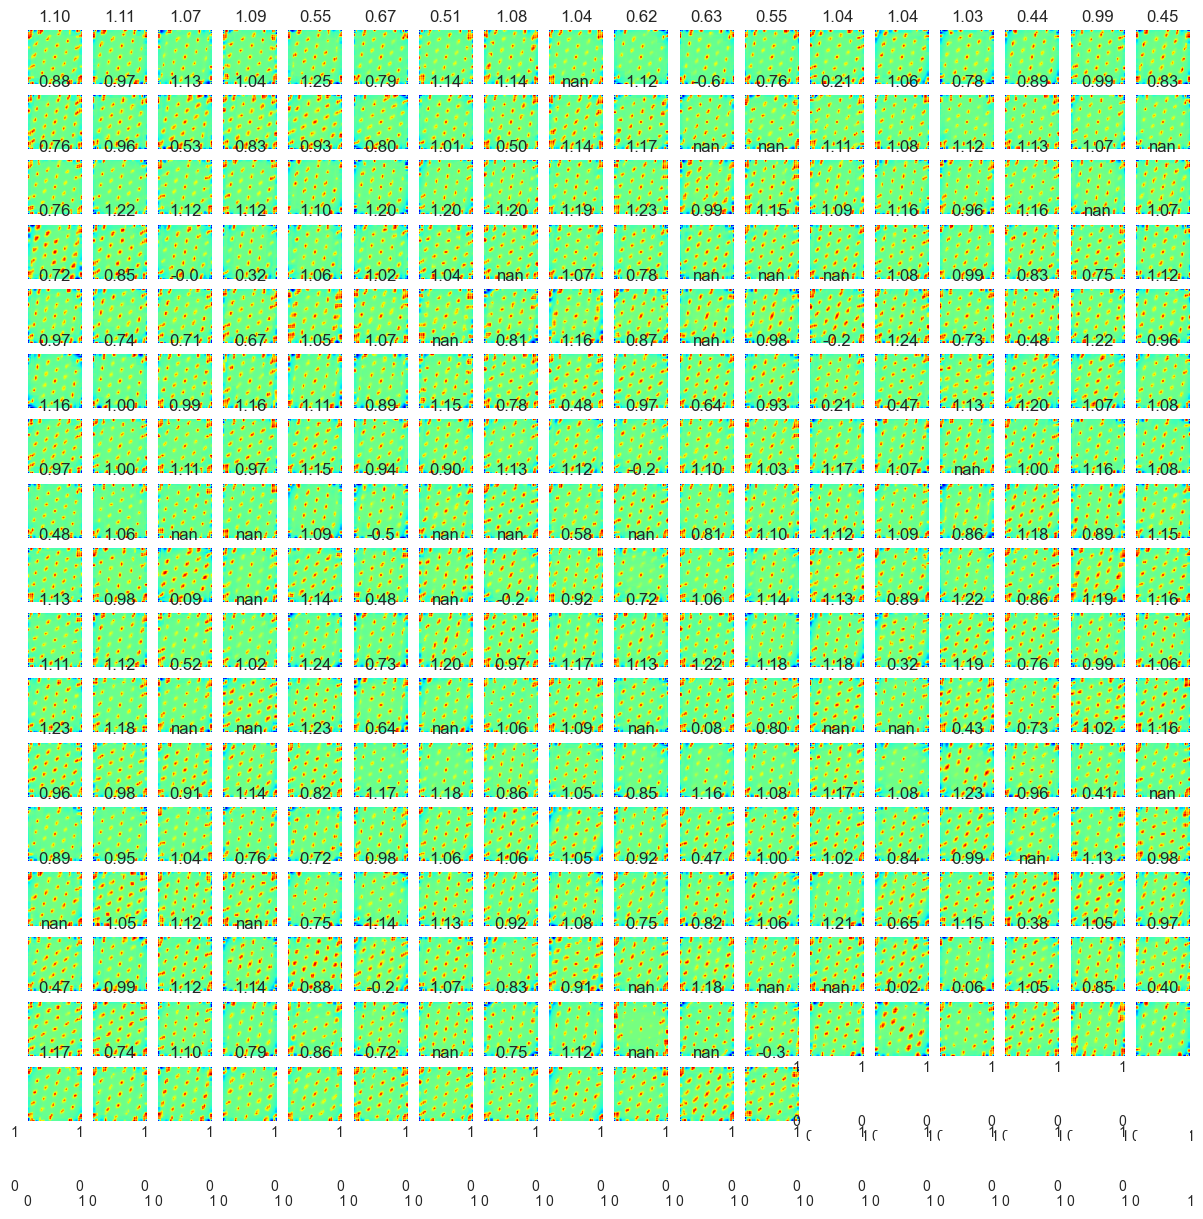

In [35]:
"""
Grid score and scale on place cells!
"""
fit_ellipse = True
ring = True

module_analysis_pc = []

env=env1

rows = np.ceil(np.sqrt(ps_[env].shape[1])).astype(int)
fix, axes = plt.subplots(rows, rows, figsize=(15, 15))

scores_all = []
for i, cell in enumerate(ps_[env].T): 
    if i%10 ==0:
        print(str(i), end=' ')
    rate_map = pf.cell_plot_prepare(cell, widths[env], masks[env], plot_specs)           
    auto = pf.autocorr2d_no_nans(rate_map) 
    auto = np.nan_to_num(auto, nan=0)
    score, scale, theta = ca.grid_score_scale_analysis(auto, fit_ellipse=fit_ellipse, ring=ring)
    scores_all.append(score)
    norm_firing = np.mean(cell**2)
    
    if score > 0.0:
        module_analysis_pc.append([i, score, scale, theta, norm_firing])
    
    ax = axes[int(i/rows)][i%rows]
    ax.imshow(auto, cmap='jet')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title(str(score)[:4])  
    ax.set_title([])  

plt.savefig(plot_specs.directory + 'auto_scores' + '_' + plot_specs.index + ".pdf", dpi=300)
plt.show()
    
scores, scales, thetas, norm_firings = [], [], [], []
for x in module_analysis_pc:
    scores.append(x[1])
    scales.append(x[2])
    thetas.append(x[3])
    norm_firings.append(x[4])
        
scores = np.asarray(scores)
scales = np.asarray(scales)
thetas = np.asarray(thetas)
norm_firings = np.asarray(norm_firings)

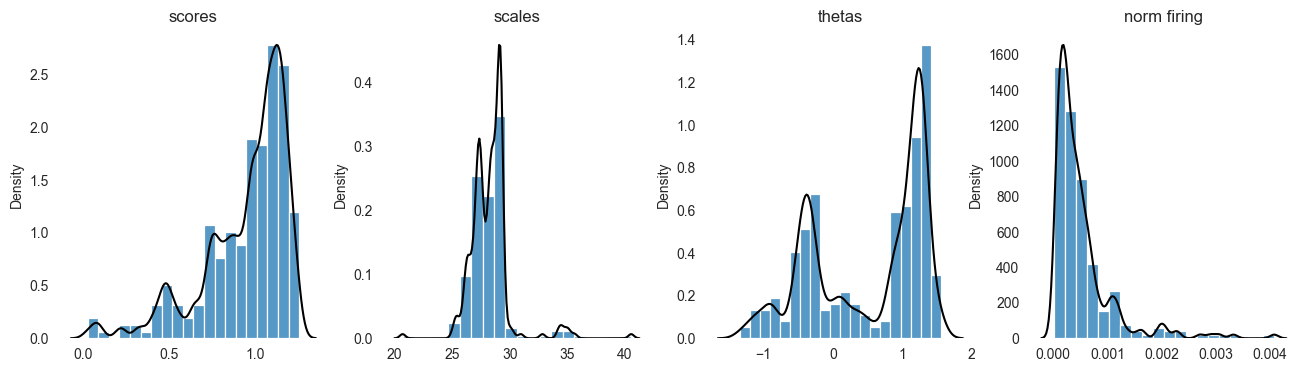

In [36]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(ax=axes[0], data=scores, bins=20, stat='density')
sns.kdeplot(ax=axes[0], data=scores, bw_method='scott', bw_adjust=0.4, c='k')
axes[0].set_title('scores')

sns.histplot(ax=axes[1], data=scales, bins=20, stat='density')
sns.kdeplot(ax=axes[1], data=scales, bw_method='scott', bw_adjust=0.4, c='k')
axes[1].set_title('scales')

sns.histplot(ax=axes[2], data=thetas, bins=20, stat='density')
sns.kdeplot(ax=axes[2], data=thetas, bw_method='scott', bw_adjust=0.4, c='k')
axes[2].set_title('thetas')

sns.histplot(ax=axes[3], data=norm_firings, bins=20, stat='density')
sns.kdeplot(ax=axes[3], data=norm_firings, bw_method='scott', bw_adjust=0.4, c='k')
axes[3].set_title('norm firing')

plt.savefig(plot_specs.directory + 'scores_scales_thetas' + '_' + plot_specs.index + ".pdf", \
            dpi=300)